# SNGP reimplemented in pyTorch

Based on [the original implementation](https://www.tensorflow.org/tutorials/understanding/sngp) in TF.

In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

## Data

In [3]:
# Visualization settings
plt.rcParams['figure.dpi'] = 140
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

In [4]:
# Data Gen
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)


def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)


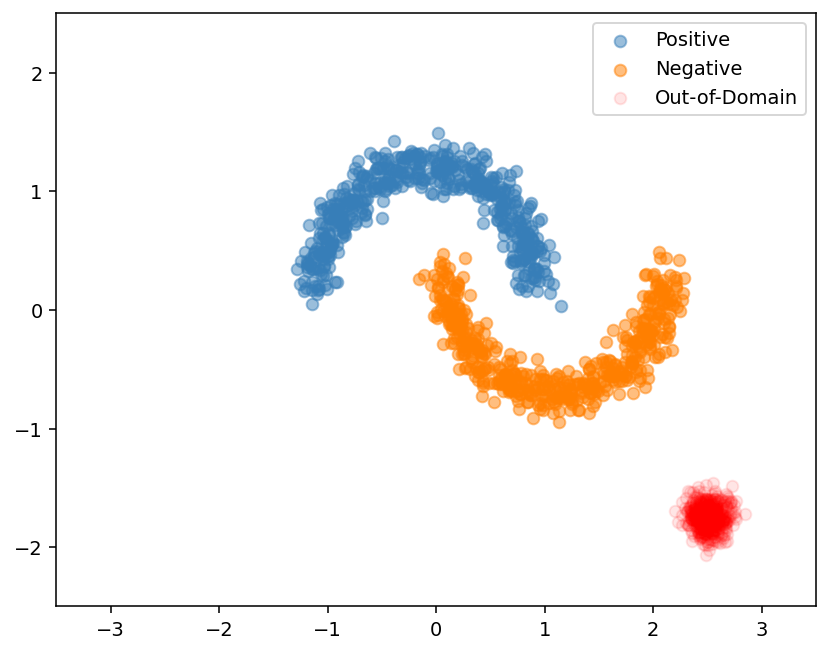

In [5]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

In [6]:
# Prepare DataLoader
batch_size = 128

dataset = TensorDataset(torch.tensor(train_examples, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.int64))
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### DeepResNet

In [7]:
class Dense(nn.Linear):
    def __init__(self, in_features, out_features, activation=None, bias=True):
        super(Dense, self).__init__(in_features, out_features, bias)
        self.activation = activation

    def forward(self, input):
        output = super(Dense, self).forward(input)
        if self.activation is not None:
            return self.activation(output)
        return output

In [8]:
class DeepResNet(nn.Module):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes, in_dim=2, num_layers=3, num_hidden=128,
                 dropout_rate=0.1, enable_residual=True, **classifier_kwargs):
        super().__init__()
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.enable_residual = enable_residual
        self.classifier_kwargs = classifier_kwargs

        self.input_layer = nn.Linear(in_dim, self.num_hidden)
        self.input_layer.weight.requires_grad = False  #! we don't train input projection
        self.input_layer.bias.requires_grad = False  #!

        self.dense_layers = nn.ModuleList([self.make_dense_layer() for _ in range(num_layers)])

        self.dropout = nn.Dropout(self.dropout_rate)

        self.classifier = self.make_output_layer(num_classes)

    def backbone(self, inputs):
        hidden = self.input_layer(inputs)

        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = self.dropout(resid)
            hidden = hidden + resid if self.enable_residual else resid

        return hidden

    def forward(self, inputs):
        hidden = self.backbone(inputs)
        return self.classifier(hidden)

    def make_dense_layer(self):
        """Uses the Linear layer as the hidden layer."""
        return Dense(self.num_hidden, self.num_hidden, nn.ReLU())

    def make_output_layer(self, num_classes):
        """Uses the Linear layer as the output layer."""
        return nn.Linear(self.num_hidden, num_classes, **self.classifier_kwargs)

In [9]:
def prepare(model_class, num_classes=2, num_layers=6, num_hidden=128, dropout_rate=0.1, lr=1e-4, **kwargs):
    model = model_class(num_classes=num_classes, num_layers=num_layers, num_hidden=num_hidden, dropout_rate=dropout_rate, **kwargs)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

In [10]:
model, criterion, optimizer = prepare(DeepResNet)
print(model)

DeepResNet(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (dense_layers): ModuleList(
    (0-5): 6 x Dense(
      in_features=128, out_features=128, bias=True
      (activation): ReLU()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)


In [11]:
num_epochs = 101
for epoch in range(num_epochs):

    model.train()
    loss_acc = 0.
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        loss_acc += batch_X.shape[0]/train_examples.shape[0] * loss.item()

    if epoch%10==0:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in train_loader:
                logits = model(batch_X)
                _, predicted = torch.max(logits.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        print(f'Epoch [{epoch}/{num_epochs}]:  loss={loss_acc:.4f}, '
            f'Train Accuracy: {100 * correct / total:.2f}%')


Epoch [0/101]:  loss=0.3400, Train Accuracy: 93.10%
Epoch [10/101]:  loss=0.0548, Train Accuracy: 98.50%
Epoch [20/101]:  loss=0.0243, Train Accuracy: 99.60%
Epoch [30/101]:  loss=0.0103, Train Accuracy: 99.80%
Epoch [40/101]:  loss=0.0068, Train Accuracy: 99.90%
Epoch [50/101]:  loss=0.0039, Train Accuracy: 100.00%
Epoch [60/101]:  loss=0.0025, Train Accuracy: 100.00%
Epoch [70/101]:  loss=0.0009, Train Accuracy: 100.00%
Epoch [80/101]:  loss=0.0006, Train Accuracy: 100.00%
Epoch [90/101]:  loss=0.0008, Train Accuracy: 100.00%
Epoch [100/101]:  loss=0.0006, Train Accuracy: 100.00%


In [12]:
resnet_preds = model(torch.tensor(test_examples, dtype=torch.float32))
resnet_probs = nn.Softmax(dim=-1)(resnet_preds)[:, 0]  # Take the probability for class 0.

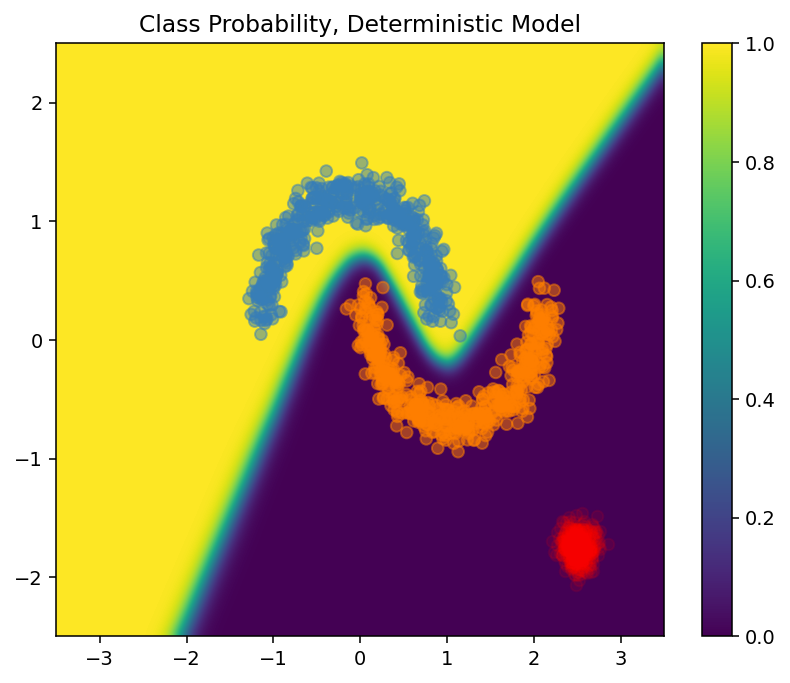

In [13]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.

  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs.cpu().detach().numpy(), ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

## DeepResNetSNGP

### Spectral Normalization Wrapper

In [14]:
class SpectralNormalization(nn.Module):
    def __init__(self, module, norm_multiplier=0.9, n_power_iterations=1, name='weight', dim=0, eps=1e-12):
        super().__init__()
        self.module = module
        self.name = name
        self.dim = dim
        self.norm_multiplier = norm_multiplier
        self.n_power_iterations = n_power_iterations
        self.eps = eps

        weight = getattr(self.module, self.name)

        with torch.no_grad():
            self.u = F.normalize(weight.data.new(weight.size(0)).normal_(0, 1), dim=0, eps=self.eps)

        self.reset_parameters()

    def reset_parameters_old(self):
        setattr(self.module, self.name, self.norm_multiplier * getattr(self.module, self.name))

    def reset_parameters(self):
        weight = getattr(self.module, self.name)
        new_weight = self.norm_multiplier * weight
        setattr(self.module, self.name, nn.Parameter(new_weight))

    def _power_method(self, weight):
        for _ in range(self.n_power_iterations):
            v = F.normalize(torch.matmul(weight.t(), self.u), dim=0, eps=self.eps)
            self.u = F.normalize(torch.matmul(weight, v), dim=0, eps=self.eps)

        sigma = torch.dot(self.u, torch.matmul(weight, v))
        return sigma, self.u, v

    def forward(self, *args):
        weight = getattr(self.module, self.name)
        sigma, _, _ = self._power_method(weight)
        weight = weight / sigma * self.norm_multiplier
        return self.module(*args)

### Spectral Normalization Wrapper - black box implementation using torch.nn.utils.spectral_norm

In [15]:
class SpectralNormalization(nn.Module):
    def __init__(self, module, norm_multiplier=0.9, n_power_iterations=1, name='weight', dim=0, eps=1e-12):
        super().__init__()
        self.module = torch.nn.utils.spectral_norm(module, name=name, n_power_iterations=n_power_iterations, eps=eps, dim=dim)
        self.norm_multiplier = norm_multiplier

    def reset_parameters(self):
        # Reset the weight parameter by applying the normalization factor
        weight = getattr(self.module, 'weight_orig')
        new_weight = self.norm_multiplier * weight
        setattr(self.module, 'weight_orig', nn.Parameter(new_weight))

    def forward(self, *args):
        # Forward pass using the spectral normalized module
        return self.module(*args)

### Random Feature GP

In [16]:
class RandomFeatureGaussianProcess(nn.Module):
    """
    Gaussian Process layer with random Fourier features approximation.

    This module uses random Fourier features to approximate Gaussian processes
    for scalable machine learning applications, following Rahimi and Recht (2007).

    Partially based on:
    https://github.com/alartum/sngp-pytorch/blob/main/sngp_pytorch/models/random_feature.py

    Args:
        units (int): Number of output units, corresponding to the dimensionality of the task.
        input_dim (int): Dimensionality of the input data.
        gp_cov_momentum (float): Momentum for updating the precision matrix during training.
        num_inducing (int): Number of random Fourier features used for the approximation.

    """
    def __init__(self, units, input_dim, num_inducing=1024, likelihood='gaussian', gp_cov_momentum=0.999, ridge_penalty=1.):
        super(RandomFeatureGaussianProcess, self).__init__()
        self.units = units
        self.num_inducing = num_inducing
        self.gp_cov_momentum = gp_cov_momentum
        self.likelihood = likelihood

        # Random Fourier features (RFF) layer
        self.projection2features = nn.Linear(input_dim, num_inducing)
        self.projection2features.weight.requires_grad_(False)
        self.projection2features.bias.requires_grad_(False)
        nn.init.kaiming_normal_(self.projection2features.weight, a=math.sqrt(5))
        nn.init.uniform_(self.projection2features.bias, 0, 2 * math.pi)

        # Linear layer to transform features into the final outputs
        self.projection2logits = nn.Linear(num_inducing, units, bias=False)
        nn.init.kaiming_normal_(self.projection2logits.weight, a=math.sqrt(5))

        # Initialize the posterior precision matrix Λ
        self.ridge_penalty = ridge_penalty
        self.precision_matrix = nn.Parameter(ridge_penalty*torch.eye(num_inducing), requires_grad=False)
        self.precision_init = self.precision_matrix.clone()

    def reset_covariance_matrix(self):
        """Reset the precision matrix Λ to its initial state, typically used at the start of each epoch."""
        self.precision_matrix.data.copy_(self.precision_init)

    def forward(self, x, training=None):
        """
        Compute the output of the GP layer, adjusting for predictive variance during inference.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            training (bool): Flag indicating whether the model is training, affecting precision matrix updates.

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, units).
        """
        training = training or self.training

        # Compute random features
        phi_x = self.compute_random_features(x)

        # Use a linear layer to compute the logits (outputs before activation)
        logits = self.projection2logits(phi_x)

        if training:
            self.update_precision_matrix(phi_x)
            return logits

        else:
            # Black-box inverse taking lower triangular of precision_matrix:  #!
            # C_theta = self.precision_matrix.cholesky_inverse()

            # Alternative implementation for full precision_matrix + ridge_penalty on diagonal  #!
            self.precision_matrix.data = F.softplus(self.precision_matrix).data
            Lambda_sym = 0.5 * (self.precision_matrix + self.precision_matrix.t()) + self.ridge_penalty * torch.eye(self.num_inducing, device=self.precision_matrix.device)
            C_theta = torch.inverse(Lambda_sym)

            var_f = torch.sum((phi_x @ C_theta) * phi_x, dim=1)

            # adjusted_logits = logits / torch.sqrt(1.0 + var_f.unsqueeze(1))
            return logits, var_f

    def compute_random_features(self, x, activation=torch.cos):
        """Generate random features for inputs x using the Fourier feature mapping."""
        return math.sqrt(2.0 / self.num_inducing) * activation(self.projection2features(x))

    def update_precision_matrix(self, phi_x):
        """Update the precision matrix Λ using the outer product of the features."""

        # https://github.com/tensorflow/models/blob/v2.15.0/official/nlp/modeling/layers/gaussian_process.py#L332C7-L332C38
        if self.likelihood == 'binary_logistic':
            logits = self.projection2logits(phi_x)
            prob = F.sigmoid(logits)  # ??
            prob_multiplier = prob * (1. - prob)
        elif self.likelihood == 'poisson':
            logits = self.projection2logits(phi_x)
            prob_multiplier = F.exp(logits)  # ??
        elif self.likelihood == 'gaussian':
            prob_multiplier = torch.tensor(1.)
        else:
            raise ValueError(f"Unknown likelihood type={self.likelihood}!")
        phi_x = torch.sqrt(prob_multiplier) * phi_x

        precision_minibatch = torch.mm(phi_x.t(), phi_x)
        if self.gp_cov_momentum < 0:
            self.precision_matrix.data = precision_minibatch.data

        else:  # running average
            self.precision_matrix.data = self.gp_cov_momentum * self.precision_matrix + (1 - self.gp_cov_momentum) * precision_minibatch


### Deep ResNet SNGP

In [17]:
class DeepResNetSNGP(DeepResNet):
    def __init__(self, spec_norm_bound=0.9, gp_classifier=True, **kwargs):
        self.spec_norm_bound = spec_norm_bound
        self.gp_classifier = gp_classifier
        super().__init__(**kwargs)

    def make_dense_layer(self):
        """Applies spectral normalization to the hidden layer."""
        dense_layer = super().make_dense_layer()
        if self.spec_norm_bound and self.spec_norm_bound > 0:
            return SpectralNormalization(dense_layer, norm_multiplier=self.spec_norm_bound)

        else:  # no spectral normalization
            # print("No spectral normalization applied!")
            return dense_layer

    def forward(self, inputs):
        hidden = self.backbone(inputs)
        if self.gp_classifier or self.training:
            return self.classifier(hidden)

        else:
            dummy_variances = torch.zeros(inputs.shape[0])
            return self.classifier(hidden), dummy_variances

    def make_output_layer(self, num_classes):
        """Uses Gaussian process as the output layer."""
        if self.gp_classifier:
            return RandomFeatureGaussianProcess(
                    num_classes,
                    input_dim=self.num_hidden,
                    **self.classifier_kwargs)

        else:
            return nn.Linear(self.num_hidden, num_classes, **self.classifier_kwargs)

In [18]:
model, criterion, optimizer = prepare(DeepResNetSNGP,
                                    #   gp_classifier=False,

                                      gp_classifier=True,
                                    #   gp_cov_momentum=-1,  # estimate on last batch only
                                      gp_cov_momentum=0.9,  # moving average over batches
                                      ridge_penalty=1e-6,
                                      likelihood="gaussian",

                                      enable_residual=True,
                                    #   enable_residual=False,  # no residual connections

                                      spec_norm_bound=0.9,
                                    #   spec_norm_bound=-1,  # no spectral normalization
                                      )
print(model)

DeepResNetSNGP(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (dense_layers): ModuleList(
    (0-5): 6 x SpectralNormalization(
      (module): Dense(
        in_features=128, out_features=128, bias=True
        (activation): ReLU()
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): RandomFeatureGaussianProcess(
    (projection2features): Linear(in_features=128, out_features=1024, bias=True)
    (projection2logits): Linear(in_features=1024, out_features=2, bias=False)
  )
)


In [19]:
num_epochs = 201
for epoch in range(num_epochs):

    # # Reset covariance matrix at the beginning of each epoch (use with gp_cov_momentum=-1)
    # if epoch>0:
    #     model.classifier.reset_covariance_matrix()

    model.train()
    loss_acc = 0.
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        loss_acc += batch_X.shape[0]/train_examples.shape[0] * loss.item()

    if epoch%10==0:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in train_loader:
                logits, variances = model(batch_X)
                logits = logits / torch.sqrt(1. + variances.unsqueeze(1))  # account for variance
                _, predicted = torch.max(logits.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        print(f'Epoch [{epoch}/{num_epochs}]:  loss={loss_acc:.4f}, '
              f'Train Accuracy: {100 * correct / total:.2f}%')


Epoch [0/201]:  loss=0.6896, Train Accuracy: 73.50%
Epoch [10/201]:  loss=0.5330, Train Accuracy: 94.10%
Epoch [20/201]:  loss=0.3965, Train Accuracy: 97.50%
Epoch [30/201]:  loss=0.2972, Train Accuracy: 98.60%
Epoch [40/201]:  loss=0.2272, Train Accuracy: 99.70%
Epoch [50/201]:  loss=0.1769, Train Accuracy: 99.70%
Epoch [60/201]:  loss=0.1414, Train Accuracy: 99.80%
Epoch [70/201]:  loss=0.1153, Train Accuracy: 99.80%
Epoch [80/201]:  loss=0.0960, Train Accuracy: 99.80%
Epoch [90/201]:  loss=0.0821, Train Accuracy: 99.90%
Epoch [100/201]:  loss=0.0692, Train Accuracy: 100.00%
Epoch [110/201]:  loss=0.0599, Train Accuracy: 100.00%
Epoch [120/201]:  loss=0.0519, Train Accuracy: 100.00%
Epoch [130/201]:  loss=0.0455, Train Accuracy: 100.00%
Epoch [140/201]:  loss=0.0402, Train Accuracy: 100.00%
Epoch [150/201]:  loss=0.0360, Train Accuracy: 100.00%
Epoch [160/201]:  loss=0.0322, Train Accuracy: 100.00%
Epoch [170/201]:  loss=0.0287, Train Accuracy: 100.00%
Epoch [180/201]:  loss=0.0269, 

In [20]:
model.eval()

# Assuming sngp_model returns logits and covariance matrix
sngp_logits, sngp_variance = model(torch.tensor(test_examples, dtype=torch.float32))
sngp_variance = sngp_variance.unsqueeze(1)

## Extract the diagonal elements of the covariance matrix
## sngp_variance = torch.diagonal(sngp_covmat, dim1=-2, dim2=-1)[:, None]

# Adjust the logits using the variance
sngp_logits_adjusted = sngp_logits / torch.sqrt(1. + (np.pi / 8.) * sngp_variance)  #! following the original implementation
# sngp_logits_adjusted = sngp_logits / torch.sqrt(1. + sngp_variance)

# Compute softmax on adjusted logits and extract the first probability
sngp_probs = torch.softmax(sngp_logits_adjusted, dim=-1)[:, 0]
# sngp_probs = torch.softmax(sngp_logits, dim=-1)[:, 0]

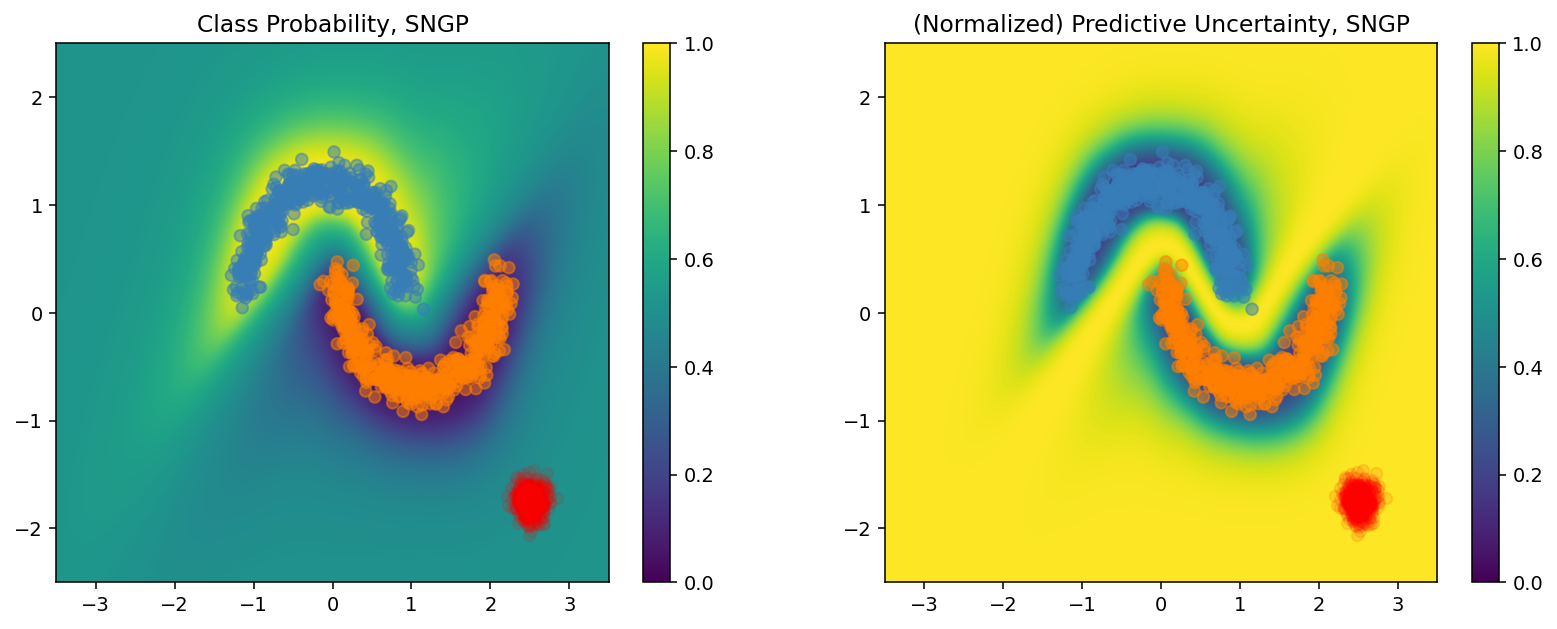

In [21]:
def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

plot_predictions(sngp_probs.cpu().detach().numpy(), model_name="SNGP")


## Classification head = [Variational Bayesian Last Layers](https://arxiv.org/abs/2404.11599)

In [22]:
!pip install vbll

In [23]:
import vbll

In [24]:
class DeepResNetSNVBLL(DeepResNet):
    def __init__(self, vbll_cfg, spec_norm_bound=0.9, **kwargs):
        # (self, num_classes, in_dim=2, num_layers=3, num_hidden=128,
        #          dropout_rate=0.1, enable_residual=True, **classifier_kwargs
        self.vbll_cfg = vbll_cfg
        self.spec_norm_bound = spec_norm_bound
        super().__init__(**kwargs)

    def make_dense_layer(self):
        """Applies spectral normalization to the hidden layer."""
        dense_layer = super().make_dense_layer()
        if self.spec_norm_bound and self.spec_norm_bound > 0:
            return SpectralNormalization(dense_layer, norm_multiplier=self.spec_norm_bound)

        else:  # no spectral normalization
            # print("No spectral normalization applied!")
            return dense_layer

    def forward(self, inputs):
        hidden = self.backbone(inputs)
        return self.classifier(hidden) # out = [out.train_loss_fn(y), out.train_loss_fn_empirical(y, train_cfg.N_SAMPLES), out.predictive.probs]

    def make_output_layer(self, num_classes):
        if self.vbll_cfg.TYPE == "disc":
            return self._make_disc_vbll_layer(self.num_hidden, self.num_classes, self.vbll_cfg)

        elif self.vbll_cfg.TYPE == "gen":
            return self._make_gen_vbll_layer(self.num_hidden, self.num_classes, self.vbll_cfg)

        else:
            raise ValueError(f"Unknown VBLL type={self.vbll_cfg.TYPE}!")

    def _make_disc_vbll_layer(self, num_hidden, num_classes, cfg):
        """ VBLL Discriminative classification head. """
        return vbll.DiscClassification( num_hidden,
                                        num_classes,
                                        cfg.REG_WEIGHT,
                                        softmax_bound=cfg.SOFTMAX_BOUND,
                                        # return_empirical=cfg.RETURN_EMPIRICAL,
                                        # softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL,
                                        parameterization = cfg.PARAM,
                                        return_ood=cfg.RETURN_OOD,
                                        prior_scale=cfg.PRIOR_SCALE,
                                       )

    def _make_gen_vbll_layer(self, num_hidden, num_classes, cfg):
        """ VBLL Generative classification head. """
        return vbll.GenClassification(  num_hidden,
                                        num_classes,
                                        cfg.REG_WEIGHT,
                                        softmax_bound=cfg.SOFTMAX_BOUND,
                                        # return_empirical=cfg.RETURN_EMPIRICAL,
                                        # softmax_bound_empirical=cfg.SOFTMAX_BOUND_EMPIRICAL,
                                        parameterization = cfg.PARAM,
                                        return_ood=cfg.RETURN_OOD,
                                        prior_scale=cfg.PRIOR_SCALE)

    def logit_predictive(self, x):
        hidden = self.backbone(x)
        return self.classifier.logit_predictive(hidden)

    def predictive(self, x, n_samples = 10):
        hidden = self.backbone(x)
        return self.classifier.predictive(hidden, n_samples)

In [25]:
# Discriminative VBLL
class cfg:
    TYPE = "disc"
    REG_WEIGHT = 1./len(train_examples)
    # PARAM = 'diagonal'
    PARAM = 'dense'
    RETURN_OOD = True
    PRIOR_SCALE = 1.
    SOFTMAX_BOUND = "jensen"
    # RETURN_EMPIRICAL = True
    # SOFTMAX_BOUND_EMPIRICAL = "montecarlo"
model, criterion, optimizer = prepare(DeepResNetSNVBLL, vbll_cfg=cfg, enable_residual=True)


# ## Generative VBLL
# class cfg:
#     TYPE = "gen"
#     REG_WEIGHT = 1./len(train_examples)
#     PARAM = 'diagonal'
#     # PARAM = 'dense'
#     RETURN_OOD = True
#     PRIOR_SCALE = 1.
#     SOFTMAX_BOUND = "jensen"
#     # RETURN_EMPIRICAL = True
#     # SOFTMAX_BOUND_EMPIRICAL = "montecarlo"


model, criterion, optimizer = prepare(DeepResNetSNVBLL, vbll_cfg=cfg, enable_residual=True, lr=0.005)

print(model)

DeepResNetSNVBLL(
  (input_layer): Linear(in_features=2, out_features=128, bias=True)
  (dense_layers): ModuleList(
    (0-5): 6 x SpectralNormalization(
      (module): Dense(
        in_features=128, out_features=128, bias=True
        (activation): ReLU()
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): DiscClassification()
)


In [26]:
num_epochs = 201
for epoch in range(num_epochs):

    model.train()
    loss_acc = 0.
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        res = model(batch_X)
        loss = res.train_loss_fn(batch_y)
        val_loss = res.val_loss_fn(batch_y)
        loss.backward()
        optimizer.step()

        loss_acc += batch_X.shape[0]/train_examples.shape[0] * val_loss.item()

    if epoch%10==0:
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in train_loader:
                res = model(batch_X)
                class_probs = res.predictive.probs
                _, predicted = torch.max(class_probs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        print(f'Epoch [{epoch}/{num_epochs}]:  val loss={loss_acc:.4f}, train loss (1 batch)={loss.item():.4f}, '
            f'Train Accuracy: {100 * correct / total:.2f}%')


Epoch [0/201]:  val loss=0.3569, train loss (1 batch)=1.8546, Train Accuracy: 90.70%
Epoch [10/201]:  val loss=0.0618, train loss (1 batch)=1.0966, Train Accuracy: 98.70%
Epoch [20/201]:  val loss=0.0199, train loss (1 batch)=0.7707, Train Accuracy: 99.80%
Epoch [30/201]:  val loss=0.0139, train loss (1 batch)=0.5987, Train Accuracy: 99.90%
Epoch [40/201]:  val loss=0.0086, train loss (1 batch)=0.4859, Train Accuracy: 100.00%
Epoch [50/201]:  val loss=0.0063, train loss (1 batch)=0.3961, Train Accuracy: 100.00%
Epoch [60/201]:  val loss=0.0059, train loss (1 batch)=0.3305, Train Accuracy: 100.00%
Epoch [70/201]:  val loss=0.0065, train loss (1 batch)=0.2848, Train Accuracy: 100.00%
Epoch [80/201]:  val loss=0.0056, train loss (1 batch)=0.2525, Train Accuracy: 100.00%
Epoch [90/201]:  val loss=0.0053, train loss (1 batch)=0.2318, Train Accuracy: 100.00%
Epoch [100/201]:  val loss=0.0065, train loss (1 batch)=0.2202, Train Accuracy: 100.00%
Epoch [110/201]:  val loss=0.0052, train loss (

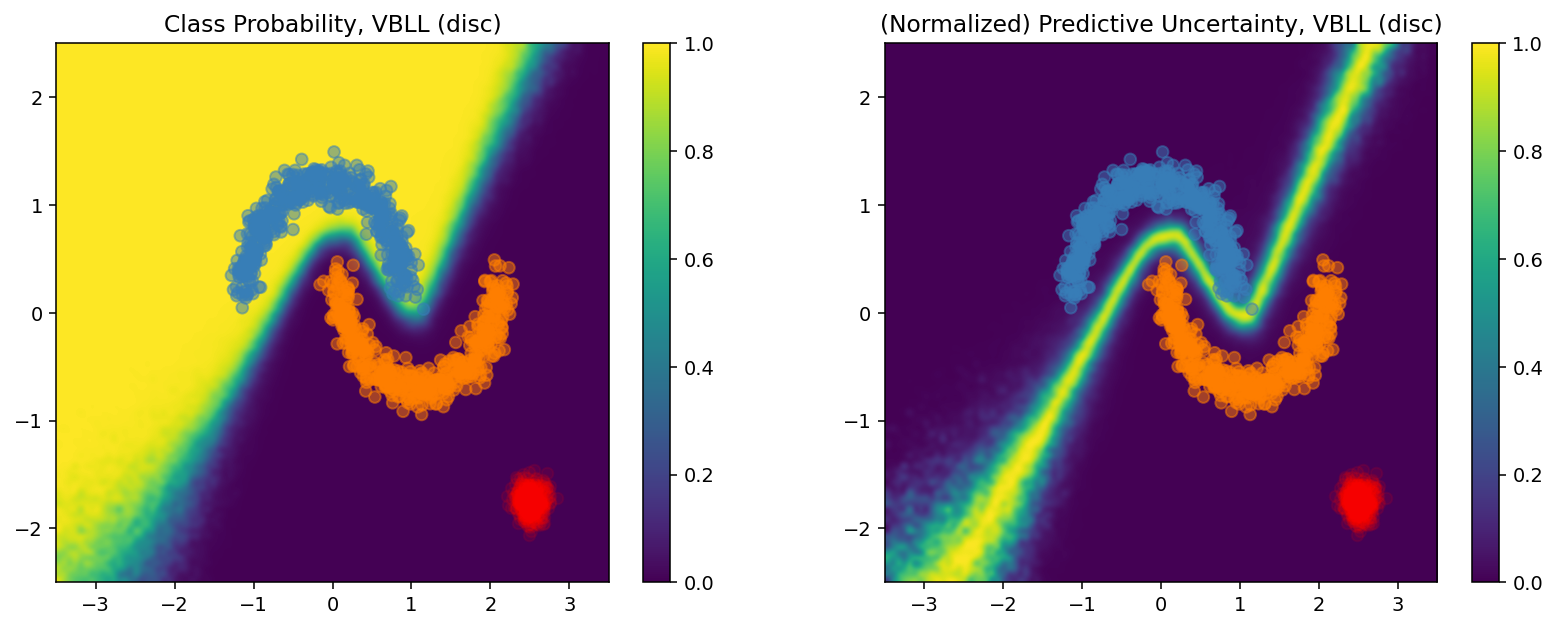

In [27]:
res = model(torch.tensor(test_examples, dtype=torch.float32))
class_probs = res.predictive.probs[:,0]


plot_predictions(class_probs.cpu().detach().numpy(), model_name=f"VBLL ({cfg.TYPE})")


In [28]:
n_samples = 100
logit_predictive = model.logit_predictive(torch.tensor(test_examples, dtype=torch.float32))
samples = logit_predictive.rsample(sample_shape=torch.Size([n_samples]))
p_values = torch.softmax(samples, dim=-1)[..., -1]

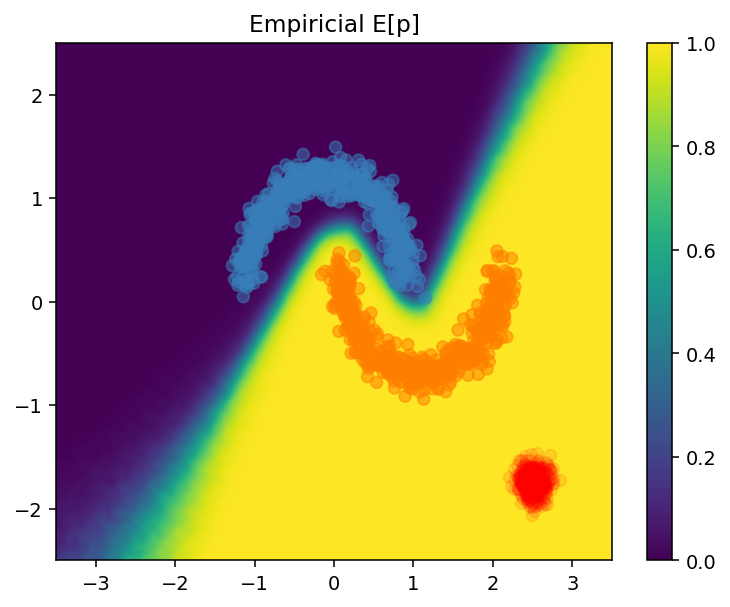

In [29]:
means = torch.mean(p_values, 0)
p = plot_uncertainty_surface(means.cpu().detach().numpy(), ax=plt.gca())
plt.colorbar(p, ax=plt.gca())
plt.title("Empiricial E[p]");

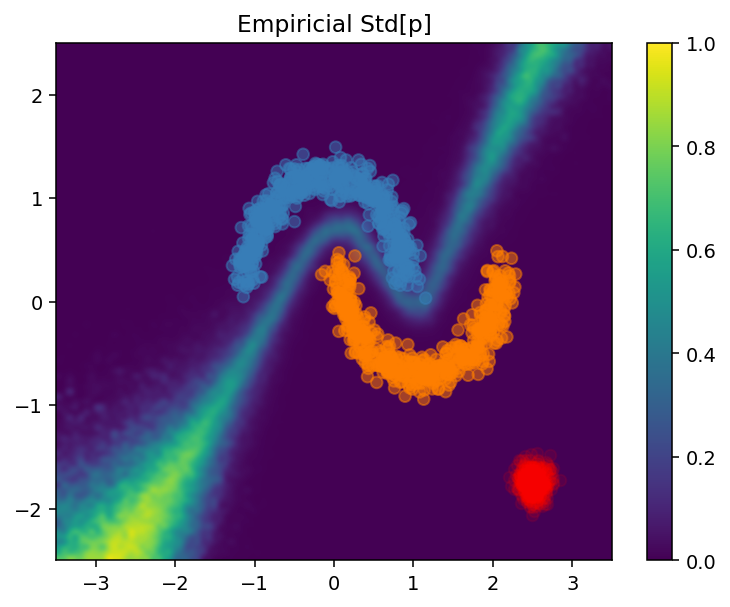

In [30]:
stds = torch.std(p_values, 0)
p = plot_uncertainty_surface(stds.cpu().detach().numpy(), ax=plt.gca())
plt.colorbar(p, ax=plt.gca())
plt.title("Empiricial Std[p]");

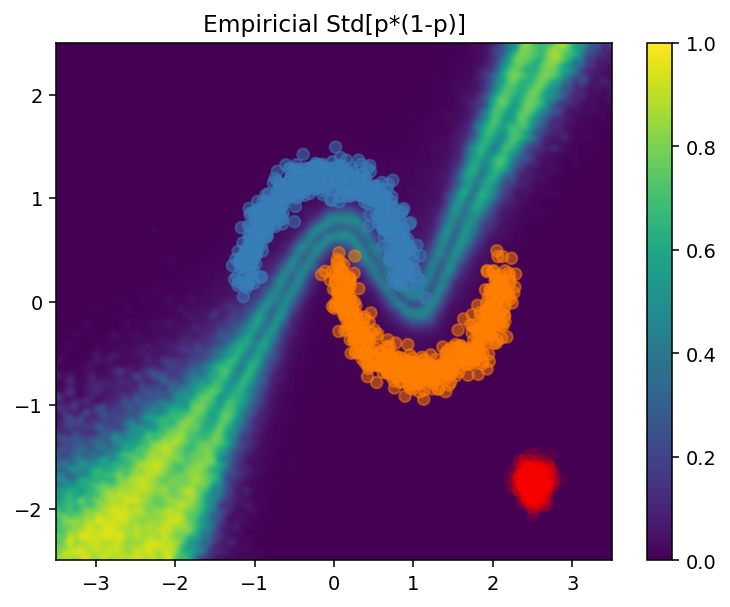

In [31]:
stds = torch.std(p_values*(1.-p_values), 0)
p = plot_uncertainty_surface(stds.cpu().detach().numpy(), ax=plt.gca())
plt.colorbar(p, ax=plt.gca())
plt.title("Empiricial Std[p*(1-p)]");

# Acknowledgements

This research is part of the project No. 2022/45/P/ST6/02969 co-funded by the National Science Centre and the European Union Framework Programme for Research and Innovation Horizon 2020 under the Marie Skłodowska-Curie grant agreement No. 945339. For the purpose of Open Access, the author has applied a CC-BY public copyright licence.

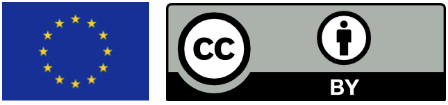

Parts of the VBLL wrapper has been based on code by Mateusz Pyla (mateuszpyla [@] gmail.com).